# <tt>synphot</tt>: Predicting count rates with ground-based and space-based telescopes

## Authors
Tiffany Jansen, Brett Morris, Pey Lian Lim, & Erik Tollerud

## Objectives
<ul>
<li>Query data directly from other websites using `astropy.coordinates.Skycoord`, `astroquery.Gaia`, `astropy.io`, and `astropy.utils`</li>
<li>Construct a source spectrum using `synphot.SourceSpectrum`</li>
<li>Simulate bandpass throughput with `synphot.SpectralElement`</li>
<li>Model effects on the source spectrum such as atmospheric transmission and quantum efficiency with `synphot.SpectralElement`</li>
<li>Combine all of these effects into a simulated observation with `synphot.Observation`</li>
<li>Compute the expected count rate from this observation with `synphot`'s `countrate()` function
</ul>

## Keywords
synphot, synthetic photometry, astropy, astroquery, astronomy

## Summary
In this tutorial we will:
<ol>
<li><a href="#query_properties">Query the properties of our target star</a> (HAT-P-11 to start)</li>
<li><a href="#phoenix">Download model spectra from PHOENIX</a></li>
<li><a href="#source_spectrum">Construct a source spectrum</a></li>
<li><a href="#bandpass">Create the bandpass of observation</a></li>
<li><a href="#atmosphere">Model attenuation by the atmosphere</a></li>
<li><a href="#qe">Model the effect of the quantum efficiency</a></li>
<li><a href="#observation">Combine all of the effects and "observe"</a></li>
<li><a href="#counts">Compute the count rate and total counts</a></li>
<li><a href="#trappist1">Look at another example, this time with TRAPPIST-1</a></li>
<li><a href="#kepler">Simulate observations with a space-based telescope</a></li>
<li><a href="#compare">Compare simulated counts to observed counts</a></li>
</ol>

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord

from astroquery.gaia import Gaia

from synphot import units
from synphot.models import Empirical1D
from synphot.spectrum import SourceSpectrum, SpectralElement
from synphot.observation import Observation

<a id='query_properties'></a>
## 1. Query the properties of HAT-P-11

First we get the star's parameters using <a href="https://astroquery.readthedocs.io/en/latest/">astroquery's</a> <a href="https://astroquery.readthedocs.io/en/latest/gaia/gaia.html">Gaia query</a>: 

In [19]:
ID = 'HAT-P-11'

coord = SkyCoord.from_name(ID)
width = u.Quantity(1, u.arcmin)  # width / height of search
height = u.Quantity(1, u.arcmin)
search_results = Gaia.query_object_async(coordinate=coord, width=width, height=height)

# the queried star will be the one nearest to the given coordinates
search_results.add_index('dist', unique=True)
hatp11_info = search_results.loc['dist', min(search_results['dist'])]

# now get the parameters
stellar_radius = hatp11_info['radius_val'] * u.R_sun
# divide 1 AU by parallax (arcseconds) to get distance in parsecs.
# parallax is given in milliarcseconds, so multiply by 1000: 
distance = (1 / (hatp11_info['parallax']) * 1000) * u.pc
T_eff = hatp11_info['teff_val']

Query finished.


<a id="phoenix"></a>
## 2. Download a model spectrum for HAT-P-11 from <a href="http://phoenix.astro.physik.uni-goettingen.de/">PHOENIX</a>:

In [20]:
T_eff = round(T_eff, -2)  # round to nearest 100 K

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=int(T_eff), log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

<a id="source_spectrum"></a>
## 3. Construct a `synphot` <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">source spectrum object</a> from the above arrays:

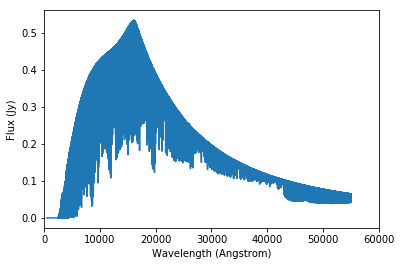

In [21]:
photlam_hatp11 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
photlam_hatp11 = photlam_hatp11 * float(stellar_radius / distance) ** 2 / np.pi

photlam_hatp11.plot(flux_unit='Jy', left=0, right=60000)

(for other methods of constructing source spectra with `synphot`, see the first bulleted list <a href="https://synphot.readthedocs.io/en/latest/synphot/spectrum.html#arrays">here</a>) 

<a id="bandpass"></a>
## Now we will simulate the observation with a specific instrument

<p>Let's observe HAT-P-11 with the <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/">ARCTIC instrument</a> on APO's 3.5m telescope.

In [22]:
aperture_radius = 3.5 / 2 * u.m  # radius of 3.5m ARC telescope at APO
aperture_area = np.pi * aperture_radius ** 2
gain = 1.9  # the gain of this detector in e-/ADU

## 4.  Create the bandpass

For the bandpass we will use the SDSS r- and z- filters whose transmission functions we query from <a href="http://svo2.cab.inta-csic.es/theory/fps/index.php?mode=voservice">SVO</a>. 
<p>To construct a bandpass from a file with <tt>synphot</tt>, use <a href="https://synphot.readthedocs.io/en/latest/api/synphot.spectrum.SpectralElement.html#synphot.spectrum">SpectralElement</a>:</p>

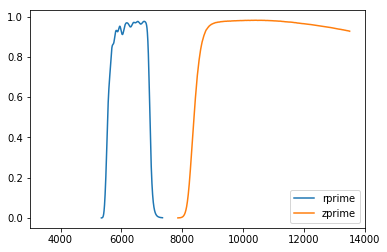

In [23]:
sdss = ['rprime', 'zprime']  # only want r' and z' bands for now
svo_sdss_link = 'http://svo2.cab.inta-csic.es/theory/fps' + \
                 '/getdata.php?format=ascii&id=SLOAN/SDSS.'

bandpasses = {}
for band in sdss:
    local_path = download_file(svo_sdss_link + band + '_filter')
    bp = SpectralElement.from_file(local_path)
    bandpasses[band] = bp
    
    plt.plot(bp.waveset, bp(bp.waveset), label=band)
plt.legend(loc='lower right')
plt.xlim(3000, 14000)
plt.show()

<a id="atmosphere"></a>
## 5. Model the attenuation by the atmosphere

Model the sky by querying results from the <a href="http://etimecalret-001.eso.org/observing/etc/bin/gen/form?INS.MODE=swspectr+INS.NAME=SKYCALC">SkyCalc Sky Model Calculator</a>:

In [41]:
import json
import requests
from astropy.io import fits

# SkyCalc recognizes Cerro Paranal by its id number 2460, which we 
# got from the skycalc_cli source code
paranal_id = '2640'

# Use the default parameters from skycalc to set up the parameter dict
params_path_https = 'https://www.eso.org/observing/etc/' + \
                                'doc/skycalc/skycalc_defaults.txt'
params_path_http = 'http://www.eso.org/observing/etc/' + \
                                'doc/skycalc/skycalc_defaults.txt'

try:
    print("Trying https (i.e. the actual link):")
    params_path = download_file(params_path_https)
except:
    print('URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED]' +
          'certificate verify failed (_ssl.c:645)>')
    try:
        print("Trying http instead:")
        params_path = download_file(params_path_http)
    except:
        print("ImportError: cannot import name 'universaldetector'")
        

params = {}
with open(params_path) as o:
    for row in o.readlines():
        columns = row.split(':')
        columns = [column.strip() for column in columns]
        key, value = columns
        
        # convert numbered values to floats
        try:
            value = int(value)
        except:
            try:
                value = float(value)
            except:
                pass
        
        params[key] = value
        
        if key == "observatory":
            params['observatory'] = paranal_id
            
# edit the parameters to your observation
params['airmass'] = 1.5
        
# Use the bit from skycalc_cli which queries from the SkyCalc Sky Model
server = 'http://etimecalret-001.eso.org'
url = server + '/observing/etc/api/skycalc'
response = requests.post(url, data=json.dumps(params))
results = json.loads(response.text)

status = results['status']
tmpdir = results['tmpdir']
tmpurl = server + '/observing/etc/tmp/' + \
         tmpdir + '/skytable.fits'

if status == 'success':
    try: 
        response = requests.get(tmpurl, stream=True)
        data = response.content
    except requests.exceptions.RequestException as e:
        print(e, 'could not retrieve FITS data from server')
else:
    print('HTML request failed', results)

Trying https (i.e. the actual link):
URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED]certificate verify failed (_ssl.c:645)>
Trying http instead:


ImportError: cannot import name 'universaldetector'

Write the data requested from the SkyCalc site to a fits file so it can be read in a human readable format:

In [ ]:
with open('data.fits', 'wb') as f:
    f.write(data)
    
hdu = fits.open('data.fits')
trans_waves = hdu[1].data["LAM"] * u.um  # wavelengths
transmission = hdu[1].data["TRANS"]

Then we combine with `synphot` so we can convolve the atmospheric effects with other parts of the observation:

In [ ]:
atmosphere = SpectralElement(Empirical1D,
                             points=trans_waves,
                             lookup_table=transmission)
atmosphere.plot()

<a id="qe"></a>
## 6. Model the affect of the CCD's quantum efficiency on the spectrum

For this we use the values in the table found in section 3.5 on <a href="https://www.apo.nmsu.edu/arc35m/Instruments/ARCTIC/#3p5">this page</a>.

In [ ]:
quantum_efficiency = SpectralElement.from_file('ccd_QE.csv', wave_unit="nm")
quantum_efficiency = quantum_efficiency / 100  # convert percentages to decimals

quantum_efficiency.plot(left=3000, right=14000)

<a id="observation"></a>
## 7. Combine all of the effects and "observe"

Once we have all of the effects on the source spectrum set, we can combine them together by simply multiplying the SpectralElement objects:

In [ ]:
bp_atmos_qe = {} # setting up a dictionary for the different SDSS bands
for band in sdss:
    bp_atmos_qe[band] = bandpasses[band] * atmosphere * quantum_efficiency
    
bp_atmos_qe['rprime'].plot(left=3000, right=14000)

Finally, we convolve the source spectrum with all of these effects using <tt>synphot</tt>'s <a href="https://synphot.readthedocs.io/en/latest/synphot/observation.html">Observation</a>:

In [ ]:
band = 'rprime'  # only want to know about the r' band

observation = Observation(photlam_hatp11, bp_atmos_qe[band])

<a id="counts"></a>
## 8. Compute the count rate and total counts

To get the expected count rate for a specific collecting area, use the <a href="https://synphot.readthedocs.io/en/latest/api/synphot.observation.Observation.html#synphot.observation.Observation.countrate">countrate()</a> method on the observation object: 

In [ ]:
countrate = observation.countrate(area=aperture_area) / gain

How many counts can we expect in a 10s exposure?

In [ ]:
counts_hatp11 = countrate * 10 * u.s

print("HAT-P-11 counts in the r-band, 10 s exposure:")
print(int(counts_hatp11.value), "cts")

<a id="trappist1"></a>
## 9. Another example, this time with <a href="https://en.wikipedia.org/wiki/TRAPPIST-1">TRAPPIST-1</a>

(using the same instrument and telescope)

In [ ]:
T_eff = 2600  # approx temperature of trappist-1 [K], Gillon 2017

url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
       'PHOENIX-ACES-AGSS-COND-2011/Z-0.0/lte{T_eff:05d}-{log_g:1.2f}-0.0.PHOENIX-'
       'ACES-AGSS-COND-2011-HiRes.fits').format(T_eff=T_eff, log_g=4.5)
# Unit from PHOENIX model file:
flux = fits.getdata(url) * (u.erg / u.s / u.cm ** 2 / u.cm)

wavelength_url = ('ftp://phoenix.astro.physik.uni-goettingen.de/v2.0/HiResFITS/'
                  'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits')
wavelengths = fits.getdata(wavelength_url) * u.Angstrom

Unfortunately Gaia does not have all the parameters we need for TRAPPIST-1, so we use the values cited in <a href="https://arxiv.org/pdf/1703.01424.pdf">Gillon 2017</a>:

In [ ]:
photlam_trappist1 = SourceSpectrum(Empirical1D,
                                points=wavelengths, lookup_table=flux)

# Scale the flux to get the value at Earth
stellar_radius = 0.117 * u.R_sun  # radius of trappist-1 in solar units
distance = 12.1 * u.pc  # distance to trappist-1 in parsecs
photlam_trappist1 = photlam_trappist1 * float(stellar_radius / distance) ** 2 / np.pi

photlam_trappist1.plot(flux_unit='Jy', left=0, right=60000)

This time I just want to know about observations in the z-band:

In [ ]:
band = 'zprime'

observation = Observation(photlam_trappist1, bp_atmos_qe[band])

countrate = observation.countrate(area=aperture_area) / gain
counts_trappist1 = countrate * 10 * u.s

print("TRAPPIST-1 counts in the z-band, 10 s exposure:")
print(int(counts_trappist1.value), "cts")

## 10. Predicting photon counts of the same stars, this time observed by a space-based telescope

The space telescope we will use as the example is <a href="https://en.wikipedia.org/wiki/Kepler_space_telescope">Kepler</a>.

First query Kepler's response function, which includes both the bandpass and the quantum efficiency:

In [ ]:
kepler_response_path = download_file('https://keplergo.arc.nasa.gov/kepler_response_hires1.txt')
kepler_response = SpectralElement.from_file(kepler_response_path, wave_unit=u.nm)
kepler_response.plot()

Create the observation object. Since Kepler is a space-based telescope, we do not need to convolve with the atmospheric transmission function:

In [ ]:
stars = {'hatp11': {'spectrum': photlam_hatp11},
         'trappist1': {'spectrum': photlam_trappist1}
        }

for star in stars.keys():
    stars[star]['observation'] = Observation(stars[star]['spectrum'], kepler_response)

Compute the counts in a  for the two stars:

In [ ]:
kepler_area = np.pi * (1.4 * u.m / 2) ** 2  # area of Kepler's primary mirror

for star in stars.keys():
    countrate = stars[star]['observation'].countrate(area=kepler_area)
    stars[star]['counts'] = countrate * 10 * u.s
    
print('synphot counts in 10s exposure:')
print('\t HAT-P-11:', round(stars['hatp11']['counts'].value / 1e6, 1), 'million')
print('\t TRAPPIST-1', round(stars['trappist1']['counts'].value / 1e3, 1), 'thousand')

<a id="compare"></a>
## 11. Comparing simulated counts to observed counts

We know from real observations (with AGILE on APO's 3.5m telescope and with Kepler) that the actual count values for these stars taken on certain dates are:

In [ ]:
hatp11_r_apo = 34000000
hatp11_kepler = 28000000
trappist1_z_apo = 203000
trappist1_kepler = 57000

In [ ]:
print('Ground-based counts at Apache Point Observatory:')
print('\t HAT-P-11 in r-band:', int(hatp11_r_apo / 1e6), 'million')
print('\t TRAPPIST-1 in z-band:', int(trappist1_z_apo / 1e3), 'thousand')
print('Space-based count rates with Kepler:')
print('\t HAT-P-11:', round(hatp11_kepler / 1e6, 1), 'million')
print('\t TRAPPIST-1', round(trappist1_kepler / 1e3, 1), 'thousand')

Comparing our `synphot` values to the observed values on a 1-1 line:

In [ ]:
fig = plt.figure(figsize=(9, 9))

plt.scatter(hatp11_r_apo, counts_hatp11,
            color='b', s=100, label="HAT-P-11, ground")
plt.scatter(hatp11_kepler, stars['hatp11']['counts'],
            color='b', marker= '^', s=100, label="HAT-P-11, space")
plt.scatter(trappist1_z_apo, counts_trappist1,
            color='r', s=100, label='TRAPPIST-1, ground')
plt.scatter(trappist1_kepler, stars['trappist1']['counts'],
            color='r', marker= '^', s=100, label='TRAPPIST-1, space')

# one-to-one line
countrange = np.linspace(1e4, 1e8, 20)
plt.plot(countrange, countrange, color='black')

plt.xscale('log')
plt.yscale('log')

plt.ylabel('synphot counts', size='14')
plt.xlabel('observed counts', size='14')

plt.legend()